<a href="https://colab.research.google.com/github/nathanschoeck/Computer-Vision/blob/main/Human_Pose_Estimation_with_MoveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/hub/tutorials/movenet

MoveNet is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on TF Hub with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.

1. Install and Import Libraries

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML, display

  Preparing metadata (setup.py) ... done


2. Helper Functions

In [ ]:
# Dictionary to map joints of body part
KEYPOINT_DICT = {
    'nose':0,
    'left_eye':1,
    'right_eye':2,
    'left_ear':3,
    'right_ear':4,
    'left_shoulder':5,
    'right_shoulder':6,
    'left_elbow':7,
    'right_elbow':8,
    'left_wrist':9,
    'right_wrist':10,
    'left_hip':11,
    'right_hip':12,
    'left_knee':13,
    'right_knee':14,
    'left_ankle':15,
    'right_ankle':16
}
# map bones to matplotlib color name
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0,1): 'm',
    (0,2): 'c',
    (1,3): 'm',
    (2,4): 'c',
    (0,5): 'm',
    (0,6): 'c',
    (5,7): 'm',
    (7,9): 'm',
    (6,8): 'c',
    (8,10): 'c',
    (5,6): 'y',
    (5,11): 'm',
    (6,12): 'c',
    (11,12): 'y',
    (11,13): 'm',
    (13,15): 'm',
    (12,14): 'c',
    (14,16): 'c'
}
def _keypoints_and_edges_for_display(keypoints_with_score,height,
                                    width,keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges"""
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances,_,_,_ = keypoints_with_score.shape
  for id in range(num_instances):
    kpts_x = keypoints_with_score[0,id,:,1]
    kpts_y = keypoints_with_score[0,id,:,0]
    kpts_scores = keypoints_with_score[0,id,:,2]
    kpts_abs_xy = np.stack(
        [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
    kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
    keypoints_all.append(kpts_above_thrs_abs)
    for edge_pair,color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_abs_xy[edge_pair[0],0]
        y_start = kpts_abs_xy[edge_pair[0],1]
        x_end = kpts_abs_xy[edge_pair[1],0]
        y_end = kpts_abs_xy[edge_pair[1],1]
        lien_seg = np.array([[x_start,y_start],[x_end,y_end]])
        keypoint_edges_all.append(lien_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all,axis=0)
  else:
    keypoints_xy = np.zeros((0,17,2))
  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all,axis=0)
  else:
    edges_xy = np.zeros((0,2,2))
  return keypoints_xy,edges_xy,edge_colors
def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image"""
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')
  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
  (keypoint_locs, keypoint_edges,
  edge_colors) = _keypoints_and_edges_for_display(
      keypoints_with_scores, height, width)
  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)
  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
  fig.canvas.draw()
  image_from_plot, _ = fig.canvas.print_to_buffer()
  image_from_plot = np.frombuffer(image_from_plot, dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
        interpolation=cv2.INTER_CUBIC)
  return image_from_plot
def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')
def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

3. Load model from Tensorflow-Hub

In [ ]:
model_name = "movenet_thunder"
if "tflite" in model_name:
  if "movenet_lightning" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite
    input_size = 192
  elif "movenet_thunder" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()
  def movenet(input_image):
    """Runs detection on an input image"""
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores
else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/3")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/3")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)
  def movenet(input_image):
    """Runs detection on an input image"""
    model = module.signatures['serving_default']
    input_image = tf.cast(input_image, dtype=tf.int32)
    outputs = model(input_image)
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

4. Infer the Model

(0.0, 1.0, 0.0, 1.0)

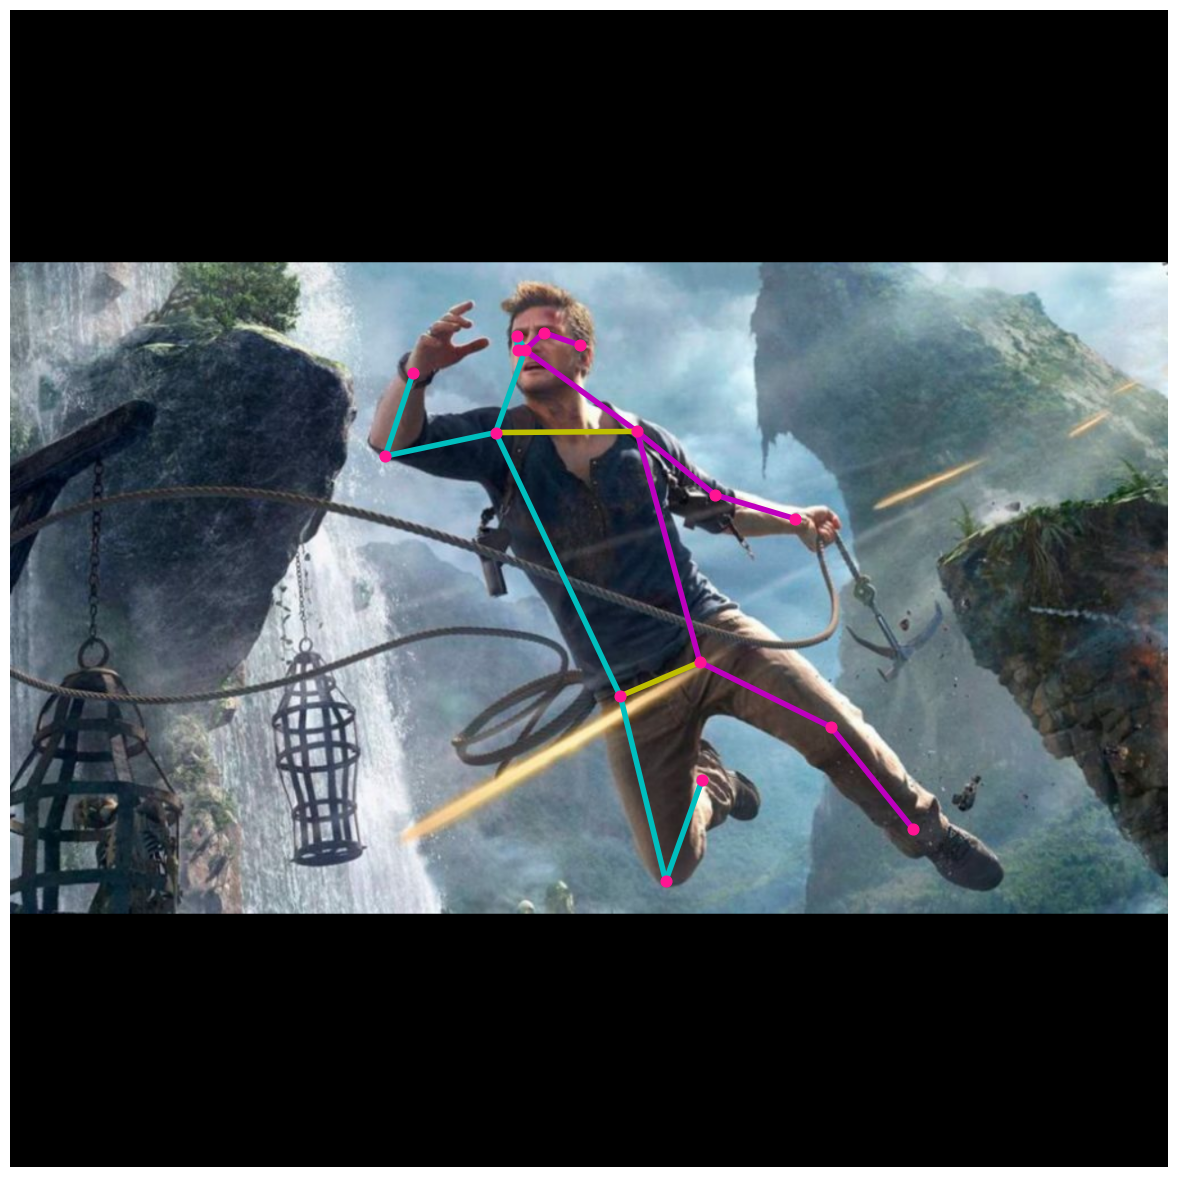

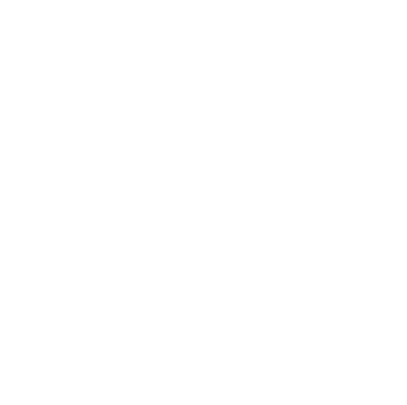

In [ ]:
image_path = '/img.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
keypoint_with_scores = movenet(input_image)
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
try:
  output_overlay = draw_prediction_on_image(
      np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)
except ValueError:
  pass
plt.figure(figsize=(5, 5))
try:
  plt.imshow(output_overlay)
except NameError:
  pass
plt.axis('off')